#Downloading the dataset

In [2]:


from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

Saving kaggle.json to kaggle.json
 97% 791M/812M [00:03<00:00, 236MB/s]
100% 812M/812M [00:03<00:00, 234MB/s]


#Copying images to training,validation and test directories

In [3]:


import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train27", start_index=0, end_index=12000)
make_subset("validation27", start_index=5000, end_index=5500)
make_subset("test27", start_index=5500, end_index=6000)

#Building the Model

In [4]:


from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

#Configuring the model for training

In [46]:


model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

#Data Processing

In [5]:


from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train27",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation27",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test27",
    image_size=(180, 180),
    batch_size=32)

Found 20000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [51]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [52]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [53]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [54]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


#Displaying the shapes of the data and labels yielded by the Dataset

In [55]:


for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


#Fitting the model using a Dataset

In [14]:

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=9,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/9
625/625 [==============================] - 7s 12ms/step - loss: 0.5734 - accuracy: 0.6991 - val_loss: 0.5743 - val_accuracy: 0.7030
Epoch 2/9
625/625 [==============================] - 7s 11ms/step - loss: 0.5661 - accuracy: 0.7102 - val_loss: 0.5671 - val_accuracy: 0.7100
Epoch 3/9
625/625 [==============================] - 7s 11ms/step - loss: 0.5572 - accuracy: 0.7171 - val_loss: 0.6786 - val_accuracy: 0.6310
Epoch 4/9
625/625 [==============================] - 7s 11ms/step - loss: 0.5515 - accuracy: 0.7204 - val_loss: 0.5494 - val_accuracy: 0.7230
Epoch 5/9
625/625 [==============================] - 7s 11ms/step - loss: 0.5447 - accuracy: 0.7265 - val_loss: 0.5463 - val_accuracy: 0.7330
Epoch 6/9
625/625 [==============================] - 7s 11ms/step - loss: 0.5368 - accuracy: 0.7320 - val_loss: 0.5392 - val_accuracy: 0.7350
Epoch 7/9
625/625 [==============================] - 7s 11ms/step - loss: 0.5318 - accuracy: 0.7373 - val_loss: 0.5306 - val_accuracy: 0.7420
Epoch 

#Displaying curves of loss and accuracy during training

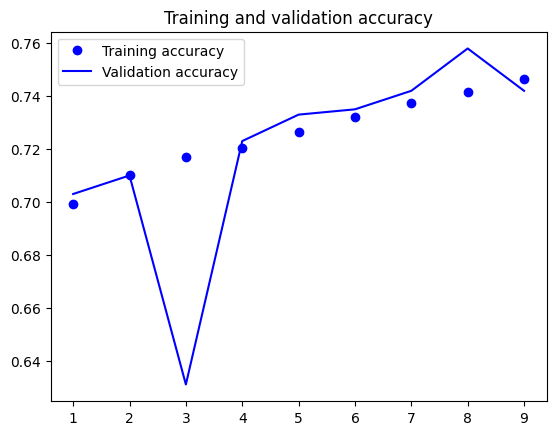

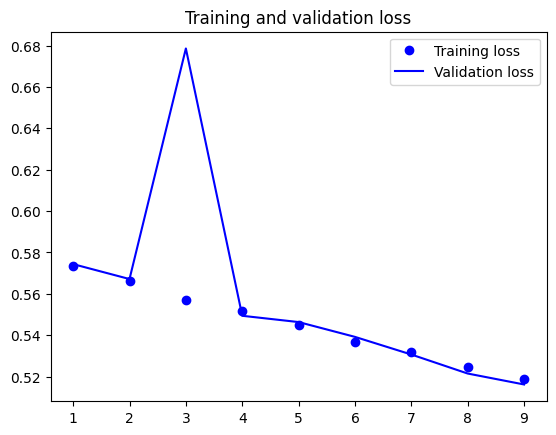

In [15]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [16]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 0s 7ms/step - loss: 0.5084 - accuracy: 0.7500
Test accuracy: 0.750


#Using data Augmentation

In [17]:
data_augmentation = keras.Sequential(
    [
       layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)



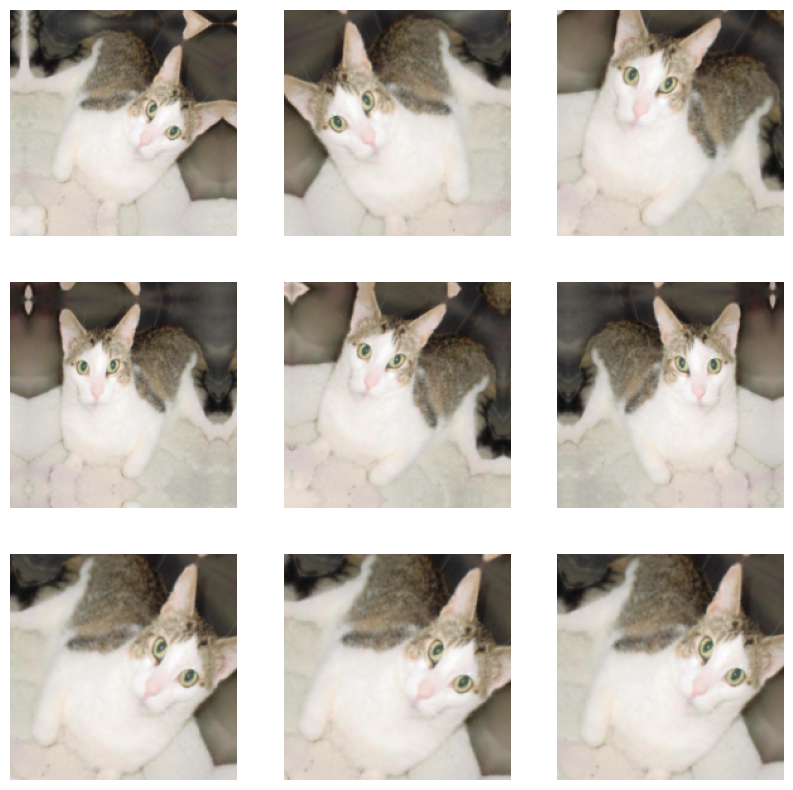

In [18]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

#Defining a new convnet that includes image augmentation and dropout

In [19]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)


x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding='same',strides=(1,1))(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same',strides=(1,1))(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same',strides=(1,1))(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same',strides=(1,1))(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same',strides=(1,1))(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.1)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])
     

#Training the regularized convnet

In [20]:

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=6,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/6
625/625 [==============================] - 12s 14ms/step - loss: 0.6460 - accuracy: 0.6140 - val_loss: 0.5516 - val_accuracy: 0.7160
Epoch 2/6
625/625 [==============================] - 9s 14ms/step - loss: 0.5473 - accuracy: 0.7199 - val_loss: 0.4561 - val_accuracy: 0.7820
Epoch 3/6
625/625 [==============================] - 8s 13ms/step - loss: 0.4782 - accuracy: 0.7711 - val_loss: 0.3993 - val_accuracy: 0.8250
Epoch 4/6
625/625 [==============================] - 8s 13ms/step - loss: 0.4207 - accuracy: 0.8086 - val_loss: 0.3074 - val_accuracy: 0.8680
Epoch 5/6
625/625 [==============================] - 8s 13ms/step - loss: 0.3618 - accuracy: 0.8401 - val_loss: 0.2858 - val_accuracy: 0.8830
Epoch 6/6
625/625 [==============================] - 9s 14ms/step - loss: 0.3237 - accuracy: 0.8611 - val_loss: 0.3418 - val_accuracy: 0.8530


#Evaluating the model on the test set

In [21]:

test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 0s 7ms/step - loss: 0.2550 - accuracy: 0.8990
Test accuracy: 0.899


#Leveraging a pretrained model 

#Feature extraction with a pretrained model

In [22]:

conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [23]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

Fast feature extraction without data augmentation

Extracting the VGG16 features and corresponding labels

In [24]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 23ms/step


In [25]:
train_features.shape

(20000, 5, 5, 512)

Defining and training the densely connected classifier

In [26]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=7,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/7
625/625 [==============================] - 3s 3ms/step - loss: 4.8867 - accuracy: 0.9628 - val_loss: 0.5936 - val_accuracy: 0.9820
Epoch 2/7
625/625 [==============================] - 2s 3ms/step - loss: 0.5201 - accuracy: 0.9772 - val_loss: 0.1383 - val_accuracy: 0.9890
Epoch 3/7
625/625 [==============================] - 2s 3ms/step - loss: 0.3122 - accuracy: 0.9845 - val_loss: 0.2010 - val_accuracy: 0.9890
Epoch 4/7
625/625 [==============================] - 2s 3ms/step - loss: 0.3021 - accuracy: 0.9863 - val_loss: 0.0362 - val_accuracy: 0.9960
Epoch 5/7
625/625 [==============================] - 2s 3ms/step - loss: 0.2630 - accuracy: 0.9906 - val_loss: 0.2123 - val_accuracy: 0.9930
Epoch 6/7
625/625 [==============================] - 2s 3ms/step - loss: 0.2258 - accuracy: 0.9931 - val_loss: 0.2307 - val_accuracy: 0.9960
Epoch 7/7
625/625 [==============================] - 2s 3ms/step - loss: 0.1825 - accuracy: 0.9942 - val_loss: 0.1098 - val_accuracy: 0.9960


Plotting the results



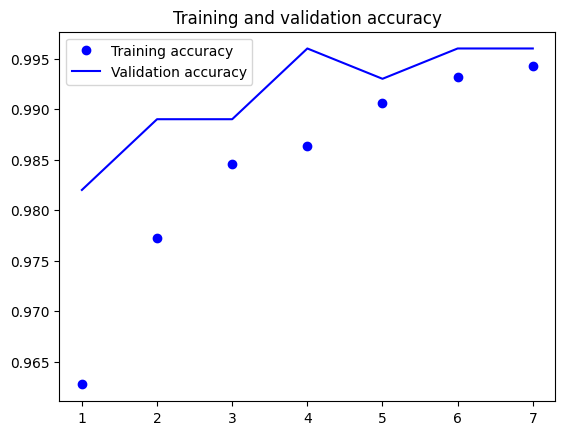

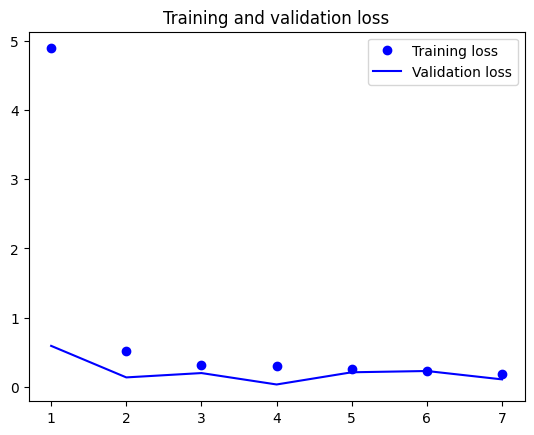

In [27]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()


**Feature extraction together with data** **augmentation**

Instantiating and freezing the VGG16 convolutional base

In [28]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

Printing the list of trainable weights before and after freezing



In [29]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [30]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


Adding a data augmentation stage and a classifier to the convolutional base

In [31]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [32]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=7,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/7
625/625 [==============================] - 15s 21ms/step - loss: 5.6340 - accuracy: 0.9389 - val_loss: 0.3048 - val_accuracy: 0.9770
Epoch 2/7
625/625 [==============================] - 13s 21ms/step - loss: 0.4182 - accuracy: 0.9496 - val_loss: 0.2406 - val_accuracy: 0.9690
Epoch 3/7
625/625 [==============================] - 13s 21ms/step - loss: 0.3771 - accuracy: 0.9582 - val_loss: 0.7630 - val_accuracy: 0.9480
Epoch 4/7
625/625 [==============================] - 13s 21ms/step - loss: 0.4185 - accuracy: 0.9580 - val_loss: 0.7537 - val_accuracy: 0.9530
Epoch 5/7
625/625 [==============================] - 13s 20ms/step - loss: 0.4046 - accuracy: 0.9629 - val_loss: 0.2418 - val_accuracy: 0.9810
Epoch 6/7
625/625 [==============================] - 13s 21ms/step - loss: 0.4290 - accuracy: 0.9639 - val_loss: 0.4404 - val_accuracy: 0.9730
Epoch 7/7
625/625 [==============================] - 13s 21ms/step - loss: 0.4378 - accuracy: 0.9649 - val_loss: 0.3178 - val_accuracy: 0.9800

Evaluating the model on the test set

In [33]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 17ms/step - loss: 0.2438 - accuracy: 0.9780
Test accuracy: 0.978


**Fine-tuning a pretrained model**

In [34]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

Freezing all layers until the fourth from the last


In [35]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False
  

Fine-tuning the model

In [36]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=7,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/7
625/625 [==============================] - 15s 20ms/step - loss: 0.2036 - accuracy: 0.9656 - val_loss: 0.0828 - val_accuracy: 0.9780
Epoch 2/7
625/625 [==============================] - 12s 19ms/step - loss: 0.0966 - accuracy: 0.9698 - val_loss: 0.0893 - val_accuracy: 0.9810
Epoch 3/7
625/625 [==============================] - 12s 19ms/step - loss: 0.0632 - accuracy: 0.9801 - val_loss: 0.1007 - val_accuracy: 0.9790
Epoch 4/7
625/625 [==============================] - 12s 20ms/step - loss: 0.0544 - accuracy: 0.9811 - val_loss: 0.0557 - val_accuracy: 0.9870
Epoch 5/7
625/625 [==============================] - 12s 20ms/step - loss: 0.0417 - accuracy: 0.9865 - val_loss: 0.0311 - val_accuracy: 0.9910
Epoch 6/7
625/625 [==============================] - 12s 19ms/step - loss: 0.0373 - accuracy: 0.9874 - val_loss: 0.0432 - val_accuracy: 0.9910
Epoch 7/7
625/625 [==============================] - 12s 19ms/step - loss: 0.0335 - accuracy: 0.9890 - val_loss: 0.1276 - val_accuracy: 0.9810

In [37]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 17ms/step - loss: 0.0326 - accuracy: 0.9910
Test accuracy: 0.991
